# Isomorphic Augmentation Experiment

In this notebook we want to test the hypothesis that most of the performance gains in the SimCLR framework come from the inductive bias of the Convolutional Neural Networks.

We will train the Resnet50 image encoder on the CIFAR10 dataset in the following setups:

1. Use the SimCLR framework with InfoNCE (NT-Xent) without the projection head and no changes to the data $f(x)$
2. Use the SimCLR framewok without the projection head and do an arbitrary permutation to the pixel's positions in the image before training. So our encoder during training will become $f(Permute(x))$
3. Use the SimCLR framewok without the projection head and do a discrete cosine transform for the image before training $f(DCOS(x))$

The goal is to compare the performance of these transformations based on:

- InfoNCE loss (The encoders are trained on 400 epochs with a batch of 120)
- Linear probing (Each in the respective domain (after information-preserving mapping)) - linear probes are trained for 20 epochs with a batch of 120
- K-means scoring

In [67]:
%load_ext autoreload
%autoreload 2

from torch import nn
import torch
import kornia.augmentation as K
from tqdm import tqdm
import torchvision.models as models

encoder = models.resnet50(pretrained=False)

random_input = torch.randn(1, 3, 224, 224)
encoder.fc = nn.Identity()
print(encoder(random_input).shape)

# TODO: write a script to load the model trained for 400 epochs and plot the losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[Parameter containing:
tensor([[[[-8.1075e-03, -1.3725e-02, -5.6979e-03,  ...,  3.0912e-02,
            1.0411e-02,  2.8021e-02],
          [-1.7983e-02,  4.9915e-03, -3.5192e-02,  ...,  4.4392e-02,
           -4.8323e-02, -1.0712e-02],
          [ 2.3515e-02,  6.8259e-03, -4.7850e-03,  ...,  5.8953e-03,
           -1.6822e-02,  3.2177e-05],
          ...,
          [ 2.9579e-03,  2.3066e-02,  7.4313e-03,  ..., -1.3768e-02,
            5.2106e-02, -1.0829e-02],
          [ 2.8334e-02,  3.0404e-03, -9.1445e-03,  ..., -4.5533e-03,
            1.0088e-02,  1.3443e-02],
          [-5.4293e-03, -2.4708e-03, -4.1151e-02,  ...,  5.1645e-03,
           -6.4355e-02, -2.3689e-02]],

         [[ 1.5294e-02, -2.3384e-02,  2.8309e-03,  ...,  2.8047e-02,
            3.5088e-02, -3.6769e-02],
          [-2.7949e-02,  2.2836e-02,  6.6553e-03,  ...,  2.0349e-02,
            4.8762e-02,  3.0718e-02],
          [ 7.11

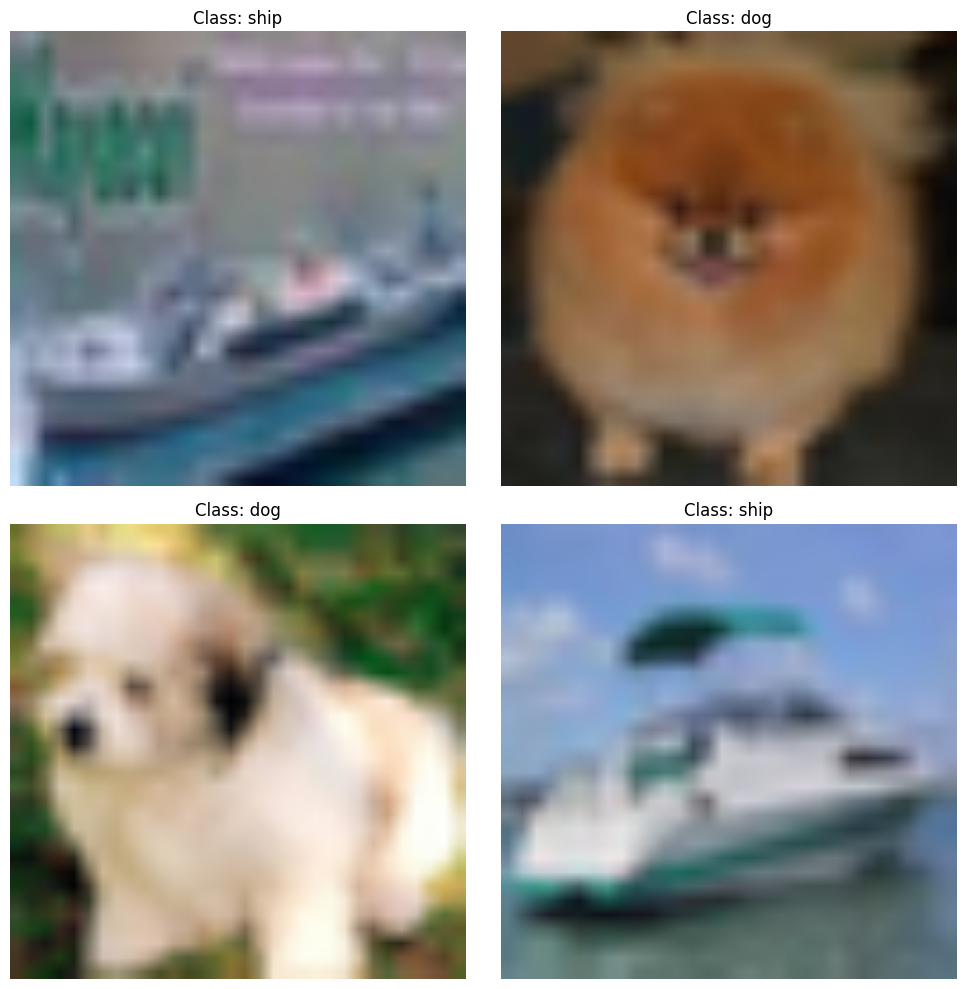

In [4]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Transformation: resize + convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
trainset = CIFAR10(root='./datasets', train=True, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Function to convert tensor to numpy image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # C x H x W -> H x W x C
    return img

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def visualize_images(plt, images):
    # Create a figure to display images
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(4):
        img = imshow(images[i])
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {classes[labels[i]]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(plt, images)

torch.Size([3, 224, 224])


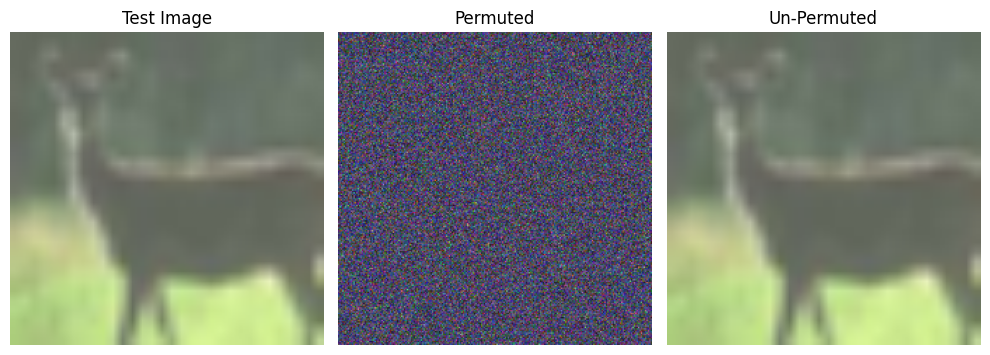

In [62]:
import torch
import torch.fft as fft

from transformations.image_permutations import ImagePermutationTransform

images, labels = next(dataiter)
test_image = images[0]

perm_transform = ImagePermutationTransform(test_image.shape[-2], test_image.shape[-1])
img_permuted = perm_transform(test_image.unsqueeze(0))
un_permuted_img = perm_transform.inverse(img_permuted)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))

print(test_image.shape)
axes[0].imshow(imshow(test_image))
axes[0].set_title(f'Test Image')
axes[0].axis('off')

axes[1].imshow(imshow(img_perm.squeeze(0)))
axes[1].set_title(f'Permuted')
axes[1].axis('off')

axes[2].imshow(imshow(un_permuted_img.squeeze(0)))
axes[2].set_title(f'Un-Permuted')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Latent Space Evaluation tools

class LinearProbeEvaluator(nn.Module):
    def __init__(self, encoder, embedding_dim, num_classes, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Freeze encoder weights
        self.encoder = encoder.to(self.device).eval()
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Projects from the latent space into the classification space
        self.classifier = nn.Linear(embedding_dim, num_classes).to(self.device)
        # Loss for classification
        self.loss_fn = nn.CrossEntropyLoss()

        # Optimizer for training the linear encoder
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)

    def train_probe(self, train_loader: DataLoader, val_loader: DataLoader = None, epochs: int = 10):
        self.classifier.train()
        print("Starting linear probe training...")

        for epoch in range(epochs):
            total_loss = 0.0
            correct = 0
            total = 0

            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
            for x, y in pbar:
                x, y = x.to(self.device), y.to(self.device)

                # Making sure no gradient is calculated here
                with torch.no_grad():
                    z = self.encoder(x)

                # Get logits
                preds = self.classifier(z)

                # Compute the cross-entropy loss on the logits
                loss = self.loss_fn(preds, y)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                
                total_loss += loss.item()
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)

                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(correct / total) * 100:.2f}%'})

            avg_loss = total_loss / len(train_loader)
            acc = correct / total * 100
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {acc:.2f}%")

            if val_loader:
                self.evaluate(val_loader)

    def evaluate(self, dataloader: DataLoader):
        self.classifier.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                z = self.encoder(x)
                preds = self.classifier(z)
                correct += (preds.argmax(dim=1) == y).sum().item()
                total += y.size(0)

        acc = correct / total * 100
        print(f"[Validation] Accuracy: {acc:.2f}%")
        self.classifier.train()
        return acc

In [23]:
# Latent Space Evaluation

lin_epochs = 3

im, c = next(iter(train_loader))

test_input_shape = trained_resnet50_identity(im[0].unsqueeze(0).to('cuda')).shape

resnet_linear_proble = LinearProbeEvaluator(trained_resnet50_identity, test_input_shape[-1], 10, device='cuda' if torch.cuda.is_available() else 'cpu')

valset = CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(valset, batch_size=100, shuffle=True, num_workers=2)

resnet_linear_proble.train_probe(train_loader, val_loader, 10)


Files already downloaded and verified
Starting linear probe training...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.21it/s, loss=2.0103, acc=28.54%]

Epoch 1: Loss = 1.9603, Accuracy = 28.54%


[Validation] Accuracy: 31.71%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.16it/s, loss=1.8503, acc=31.08%]


Epoch 2: Loss = 1.8914, Accuracy = 31.08%
[Validation] Accuracy: 31.90%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.18it/s, loss=1.8271, acc=32.73%]

Epoch 3: Loss = 1.8630, Accuracy = 32.73%


[Validation] Accuracy: 34.12%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.10it/s, loss=2.0524, acc=34.05%]

Epoch 4: Loss = 1.8325, Accuracy = 34.05%


[Validation] Accuracy: 34.37%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.16it/s, loss=1.6910, acc=34.94%]

Epoch 5: Loss = 1.8090, Accuracy = 34.94%


[Validation] Accuracy: 34.24%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.04it/s, loss=1.8313, acc=35.53%]


Epoch 6: Loss = 1.7958, Accuracy = 35.53%
[Validation] Accuracy: 35.08%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.04it/s, loss=2.0231, acc=36.00%]

Epoch 7: Loss = 1.7864, Accuracy = 36.00%


[Validation] Accuracy: 35.78%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.09it/s, loss=1.7561, acc=36.47%]


Epoch 8: Loss = 1.7671, Accuracy = 36.47%
[Validation] Accuracy: 36.13%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.92it/s, loss=1.5796, acc=37.20%]


Epoch 9: Loss = 1.7564, Accuracy = 37.20%
[Validation] Accuracy: 37.32%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.97it/s, loss=1.7236, acc=37.32%]


Epoch 10: Loss = 1.7522, Accuracy = 37.32%
[Validation] Accuracy: 37.51%


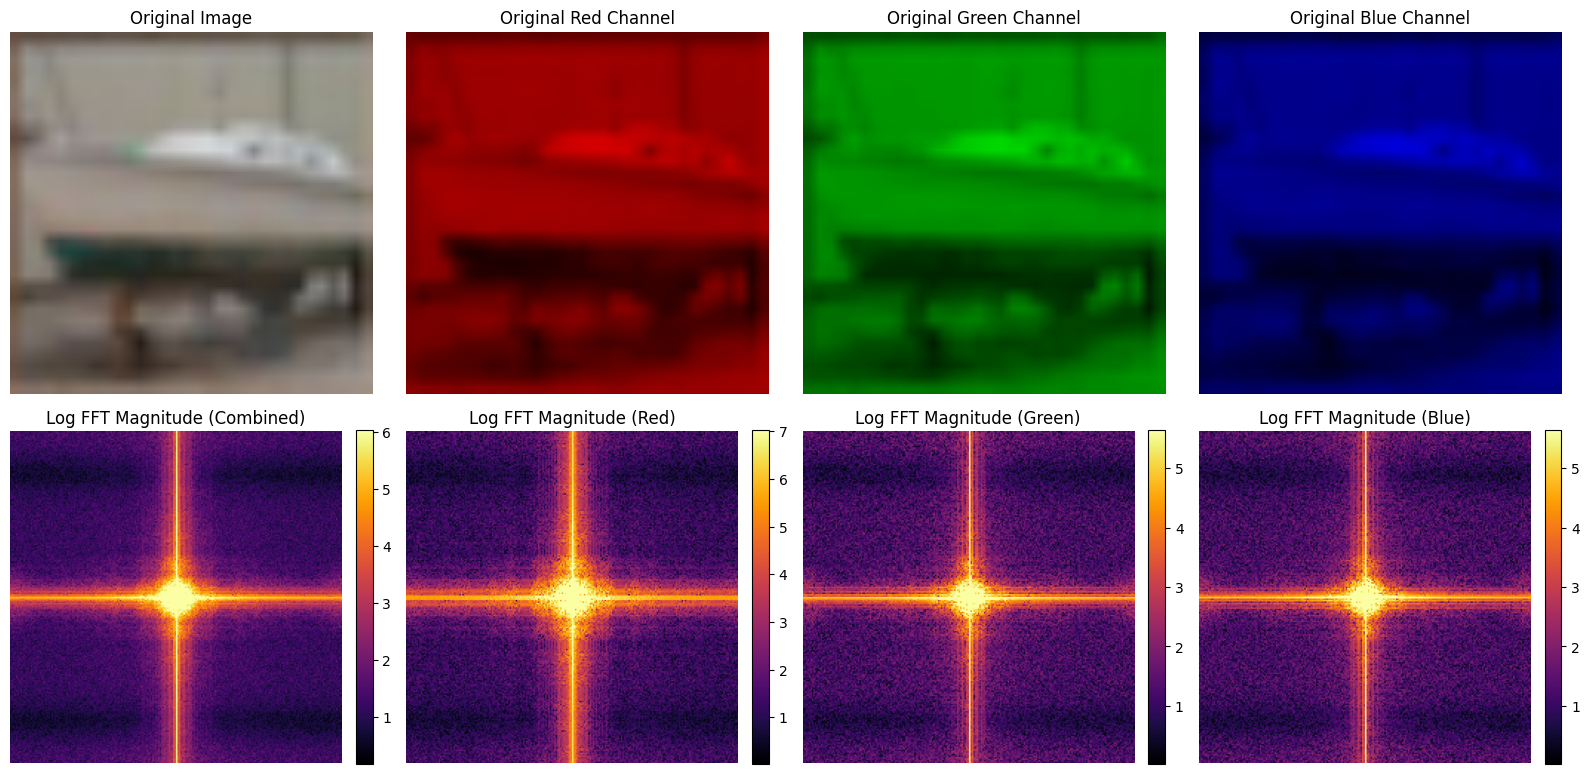

In [216]:
# Visualize the dataset after fourier transform

from torch.fft import fftn, fftshift
import torch
import matplotlib.pyplot as plt
import numpy as np

images_fft = fftn(images)

def visualize_fft_improved(images, images_fft, index=0):
    # Get the original image and its FFT result
    image = images[index]
    fft_result = images_fft[index]
    
    # For visualization, we need to use fftshift to center the zero frequency component
    fft_shifted = fftshift(fft_result, dim=(-2, -1))
    
    # Calculate the magnitude spectrum with logarithmic scaling for better visualization
    # log(1+x) helps to enhance the visibility of details
    magnitude_spectrum = torch.log1p(torch.abs(fft_shifted))
    
    # Move tensors to CPU and convert to numpy for plotting
    image_np = image.cpu().permute(1, 2, 0).numpy()
    
    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Show original image
    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Show each channel separately
    for i in range(3):
        channel_name = ['Red', 'Green', 'Blue'][i]
        
        # Original channel
        single_channel = np.zeros_like(image_np)
        single_channel[:, :, i] = image_np[:, :, i]
        axes[0, i+1].imshow(single_channel)
        axes[0, i+1].set_title(f'Original {channel_name} Channel')
        axes[0, i+1].axis('off')
        
        # FFT magnitude for this channel
        mag_channel = magnitude_spectrum[i].cpu().numpy()
        
        # Clip values for better color distribution (adjusting as needed)
        # This helps to highlight patterns that might be hidden otherwise
        vmax = np.percentile(mag_channel, 99)  # Use 99th percentile as max to ignore outliers
        
        im = axes[1, i+1].imshow(mag_channel, cmap='inferno', vmax=vmax)
        axes[1, i+1].set_title(f'Log FFT Magnitude ({channel_name})')
        axes[1, i+1].axis('off')
        plt.colorbar(im, ax=axes[1, i+1], fraction=0.046, pad=0.04)
    
    # Show combined FFT magnitude (average across channels)
    combined_mag = torch.mean(magnitude_spectrum, dim=0).cpu().numpy()
    vmax_combined = np.percentile(combined_mag, 99)
    im = axes[1, 0].imshow(combined_mag, cmap='inferno', vmax=vmax_combined)
    axes[1, 0].set_title('Log FFT Magnitude (Combined)')
    axes[1, 0].axis('off')
    plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Call the function
visualize_fft_improved(images, images_fft, index=0)

In [221]:
# Load non-pretrained ResNet50 and train with SimCLR
resnet50 = models.resnet50(pretrained=False)
trained_resnet50_identity, losses = SimCLR(resnet50, train_loader, fftn, 224, 224).train()

Using device: cpu
Starting training


Epoch 1/10:   0%|                                                                                                                                                                            | 0/1000 [00:07<?, ?it/s]


TypeError: Expected input of [torch.float16, torch.float32, torch.float64]. Got torch.complex64